In [1]:
import pickle

data_to_load = {
    "X_train": None,
    "X_valid": None,
    "X_test": None,
    "y_train": None,
    "y_valid": None,
    "y_test": None,
    "y_mean": None, 
    "y_std": None,
    "df_test": None
}
for k in data_to_load.keys():
    with open(k + ".pkl", 'rb') as file:
        data_to_load[k] = pickle.load(file)
X_train, X_valid, X_test = data_to_load["X_train"], data_to_load["X_valid"], data_to_load["X_test"]
y_train, y_valid, y_test = data_to_load["y_train"], data_to_load["y_valid"], data_to_load["y_test"]
y_mean, y_std = data_to_load["y_mean"], data_to_load["y_std"]
df_test = data_to_load["df_test"]

In [2]:
shape = X_train.shape[1]
X_train = X_train.values.reshape(-1, shape, 1)
X_valid = X_valid.values.reshape(-1, shape, 1)
X_test = X_test.values.reshape(-1, shape, 1)

In [3]:
from tensorflow.keras import layers, losses, regularizers, optimizers
import tensorflow as tf

model = tf.keras.Sequential([
    layers.Conv1D(32, kernel_size=11, strides=3),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=3, strides=2),
    
    layers.Conv1D(64, kernel_size=5, strides=3),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2, strides=1),
    
    layers.Conv1D(128, kernel_size=3, strides=2),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2, strides=1),
    
    layers.Flatten(),
    layers.Dense(256, activation="swish", kernel_regularizer=regularizers.l2(0.002)),
    layers.Dense(1, kernel_regularizer=regularizers.l2(0.002))
])

model.compile(optimizer=optimizers.Adam(0.0005), loss="mse", metrics=["mae", "mape"])

history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), batch_size=256
)
model.save('cnn')

Epoch 1/20
2360/2360 [==============================] - 113s 47ms/step - loss: 1.2401 - mae: 0.7116 - mape: 1410.3616 - val_loss: 0.9786 - val_mae: 0.7066 - val_mape: 2201.7947
Epoch 2/20
2360/2360 [==============================] - 111s 47ms/step - loss: 0.9131 - mae: 0.7040 - mape: 387.0215 - val_loss: 0.9063 - val_mae: 0.7096 - val_mape: 1736.9545
Epoch 3/20
2360/2360 [==============================] - 109s 46ms/step - loss: 0.8937 - mae: 0.7041 - mape: 602.3920 - val_loss: 0.9109 - val_mae: 0.7129 - val_mape: 2005.1652
Epoch 4/20
2360/2360 [==============================] - 109s 46ms/step - loss: 0.8916 - mae: 0.7038 - mape: 1126.9302 - val_loss: 0.9038 - val_mae: 0.7077 - val_mape: 1511.3623
Epoch 5/20
2360/2360 [==============================] - 108s 46ms/step - loss: 0.8893 - mae: 0.7033 - mape: 643.3685 - val_loss: 0.9019 - val_mae: 0.7079 - val_mape: 1070.3163
Epoch 6/20
2360/2360 [==============================] - 109s 46ms/step - loss: 0.8879 - mae: 0.7030 - mape: 809.6033 -

INFO:tensorflow:Assets written to: cnn\assets


INFO:tensorflow:Assets written to: cnn\assets


In [4]:
import pandas as pd
import scutquant.scutquant as q

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=y_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

8808/8808 [==============================] - 20s 2ms/step


,predict
count,281840.000000
mean,-0.000260
std,0.003091
min,-0.030494
25%,-0.001900
50%,0.000114
75%,0.001824
max,0.032810


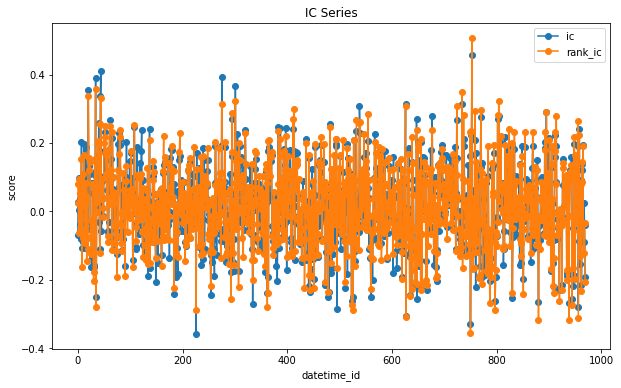

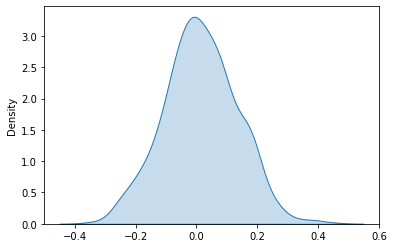

ic= 0.013590220488170213 icir= 0.11179456554257278 rank_ic= 0.015585230503459772 rank_icir= 0.12656245335591174


0.013334458776297905

In [5]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

Accuracy of Prediction: 0.5283347430220409


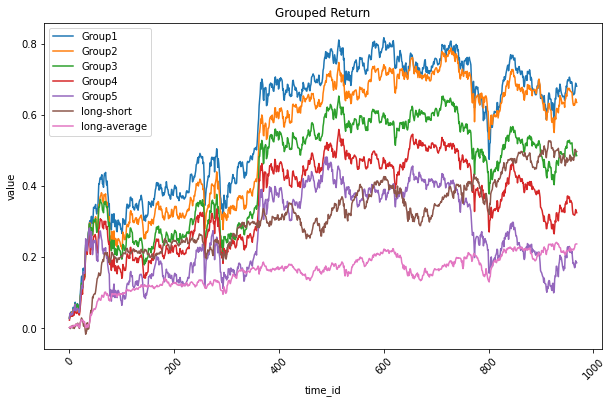

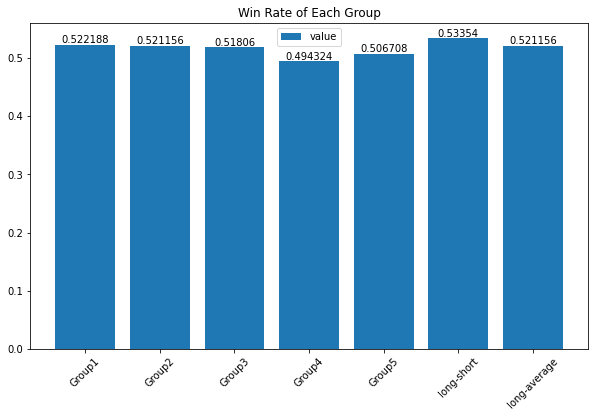

In [6]:
from scutquant import executor, report

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')
report.group_return_ana(pred, y_test)

In [7]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "SigmaStrategy",  # 做多预测值前20%且值大于0.5%的股票, 做空后20%且值小于0.5%的股票. 自动平仓
        "kwargs": {
            "sigma": 1,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 5000,
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.55  # 手数随可用资金而改变，最大不会超过股票当天成交量的x%(例如T+1时下单，下单手数不会超过T时成交量的x%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

Annualized Return: 0.07383156391598877
Annualized Volatility: 0.2859044128298869
Annualized Return(Benchmark): 0.07899686073853784
Annualized Volatility(Benchmark): 0.3389941216655789 

Cumulative Rate of Return: 0.31509437906995297
Cumulative Rate of Return(Benchmark): 0.33958556303554865
Cumulative Excess Rate of Return: -0.024491183965595686 

Max Drawdown: -0.3893527787480451
Max Drawdown(Benchmark): -0.5462600364770351 

Sharpe Ratio: 2.50090374560049
Sortino Ratio: -0.32748906991692406
Information Ratio: -0.3418583386419343 

Beta: 0.8059908063272958
Alpha: 0.030584791781093412
Epsilon: 0.04293633287192439
Profitable Days(%): 0.18369453044375644


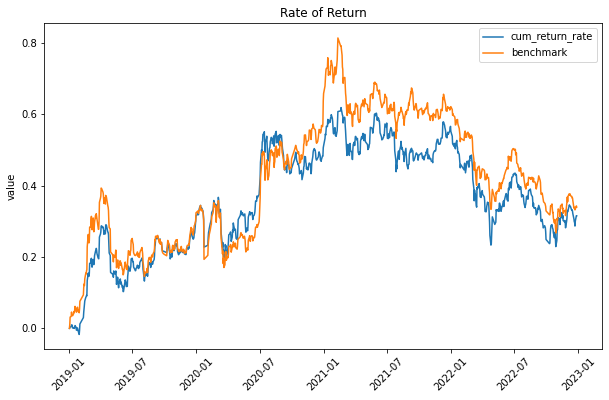

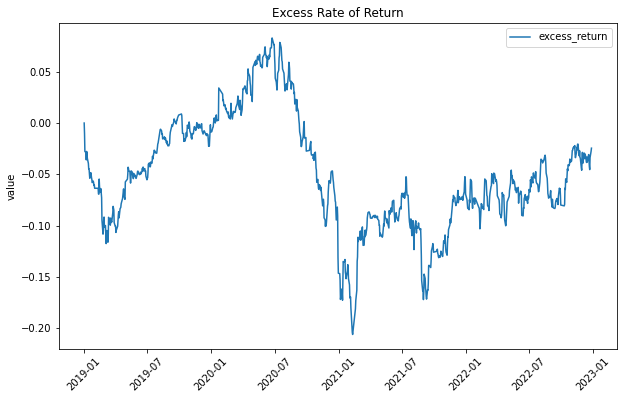

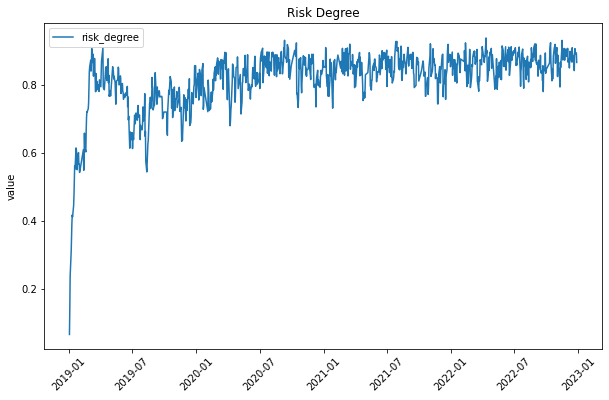

In [8]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节